<a href="https://colab.research.google.com/github/lphuong304/CS116.M11/blob/main/STOCK_PRICE_PREDICT_LOOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>CS116.M11 - LẬP TRÌNH PYTHON CHO MÁY HỌC</b></h1>
<h1 align="center"><b>SUPPORT VECTOR REGRESSION</b></h1>

# **Thông tin nhóm**
1. ***19520227 - Nguyễn Ngọc Lan Phương - 19520227@gm.uit.edu.vn*** 
2. ***19520214 - Cao Hưng Phú - 19520214@gm.uit.edu.vn*** 
3. ***19521216 - Trần Huỳnh Kỳ Anh - 19521216@gm.uit.edu.vn*** 

#1. Cài đặt thư viện cần thiết

In [2]:
!pip install stockai
!pip install ciso8601==2.1.3
!pip install requests==2.25.1
!pip install loguru==0.5.3
!pip install pandas_ta

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 57 kB 3.1 MB/s 
  Created wheel for ciso8601: filename=ciso8601-2.2.0-cp37-cp37m-linux_x86_64.whl size=37539 sha256=0c6f87a3a05b53451eb9fab44766d06398fa8d7e78b3d3faeccc7151eb39fecd
  Stored in directory: /root/.cache/pip/wheels/ad/25/8f/3b0a82303191efe3c1204f3741c42d8eb2b0236567e22485de
Successfully built ciso8601
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp37-cp37m-linux_x86_64.whl size=29120 sha256=dda1876ec9934ce7d5ded8d302f8e5acd37b133015c6e1ee0fe9097a0ff9187e
  Stored in directory: /root/.cache/pip/wheels/96/0f/89/b1c8e876a1c8ebf41226adea77b12c4540ffc323006124954d
Successfully built ciso8601
  Attempting uninstall: ciso8601
    Found existing installation: ciso8601 2.2.0
    Uninstalling ciso8601-2.2.0:
      Successfully uninstalled ciso8601-2.2.0
     |████████████████████████████████| 61 kB 4.6 MB/s 
  

In [4]:
!pip install yfinance --upgrade --no-cache-dir

In [5]:
from stockai import Stock
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import sklearn.gaussian_process as gp
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
import time

#2. Thu thập dữ liệu + EDA

In [6]:
import yfinance as yf
from pandas_datareader import data as pdr

#load stock information of SPY
data_train_raw = yf.download('SPY', start='2020-06-01', end="2021-05-30")
data_test_raw = yf.download('SPY', start='2021-06-01', end="2021-11-30")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
data_train = data_train_raw[['Close']]
data_test = data_test_raw[['Close']]

#3. Minh hoạ dữ liệu

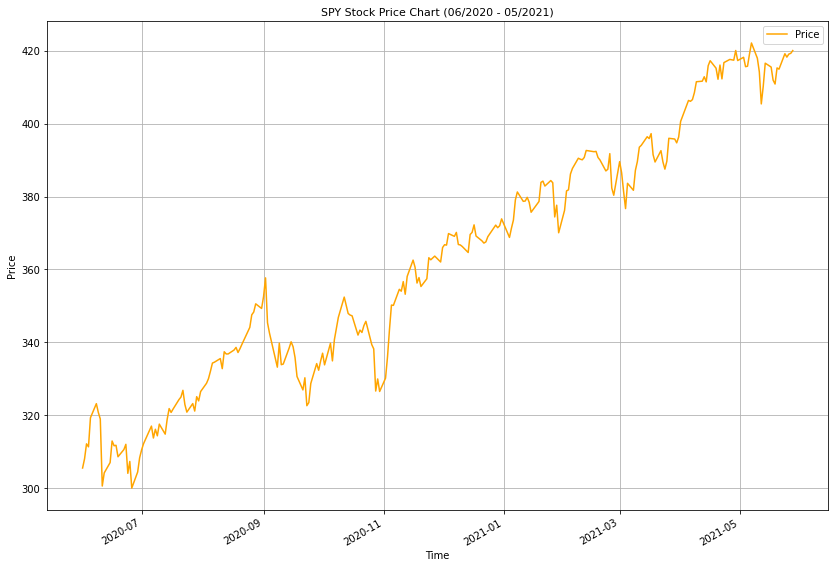

In [8]:
# Visualize data by matpltotlib
stocks_spy = data_train.copy()
plt.figure(figsize=(14,10))
ax1 = stocks_spy.Close.plot(kind = 'line',color = 'orange',label='Close' )
ax1.legend(['Price'])
ax1.set(xlabel="Time", ylabel = 'Price')
plt.title('SPY Stock Price Chart (06/2020 - 05/2021)', fontsize = 11)
plt.grid()
plt.show()

#4. Tiền xử lý dữ liệu
### Để thêm các thuộc tính cho việc dự đoán giá cổ phiếu theo chuỗi thời gian, nhóm quyết định chỉ số Chỉ báo kĩ thuật (Technical Indicator) được định nghĩa là các kinh nghiệm hoặc sự tính toán dựa trên giá, khối lượng hay lãi suất mở của một chứng khoán hoặc một hợp đồng, được những người giao dịch theo phân tích kĩ thuật sử dụng. Đây là một chỉ số có quan hệ chặt chẽ để dự đoán giá cổ phiếu theo thời gian.

In [9]:
data_train.ta.ema(close='Close', length=10, append=True)

Date
2020-06-01           NaN
2020-06-02           NaN
2020-06-03           NaN
2020-06-04           NaN
2020-06-05           NaN
                 ...    
2021-05-24    415.033674
2021-05-25    415.616640
2021-05-26    416.244525
2021-05-27    416.798249
2021-05-28    417.387660
Name: EMA_10, Length: 252, dtype: float64

In [10]:
data_test.ta.ema(close='Close', length=10, append=True)

Date
2021-06-01           NaN
2021-06-02           NaN
2021-06-03           NaN
2021-06-04           NaN
2021-06-07           NaN
                 ...    
2021-11-22    467.179842
2021-11-23    467.363508
2021-11-24    467.741052
2021-11-26    466.146316
2021-11-29    465.865168
Name: EMA_10, Length: 127, dtype: float64

In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2021-06-01 to 2021-11-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   127 non-null    float64
 1   EMA_10  118 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [12]:
data_train = data_train.dropna()
data_test = data_test.dropna()

In [13]:
data_train

,Close,EMA_10
Date,,
2020-06-12,304.209991,312.431995
2020-06-15,307.049988,311.453448
2020-06-16,312.959991,311.727365
2020-06-17,311.660004,311.715117
2020-06-18,311.779999,311.726914
...,...,...
2021-05-24,419.170013,415.033674
2021-05-25,418.239990,415.616640
2021-05-26,419.070007,416.244525


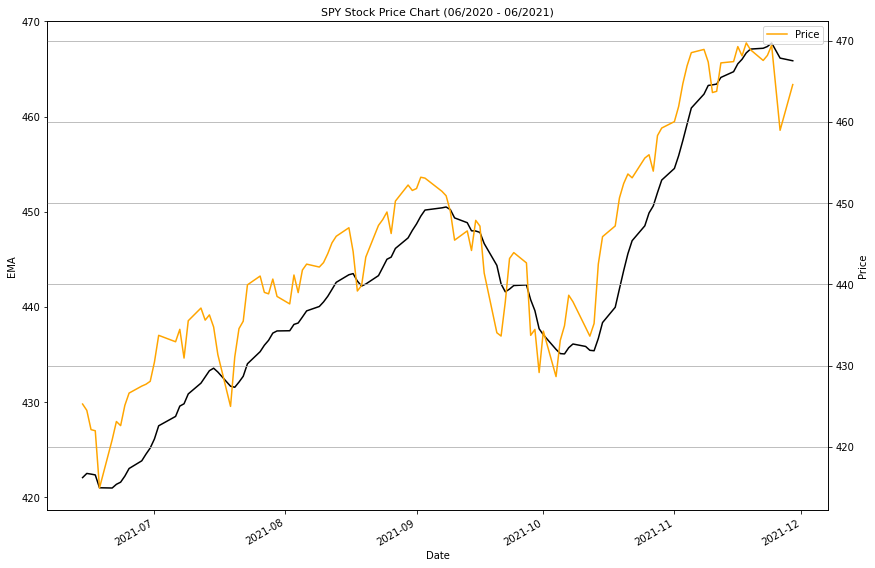

In [14]:
# Visualize data by matpltotlib
stocks_spy = data_test.copy()
plt.figure(figsize=(14,10))
ax = stocks_spy.EMA_10.plot(kind = 'line', color='black', label='EMA')
ax1 = ax.twinx()
ax1 = stocks_spy.Close.plot(kind = 'line',color = 'orange',label='Close' )
ax1.legend(['Price'])
ax.set(ylabel = 'EMA')
ax1.set(xlabel="Time", ylabel = 'Price')
plt.title('SPY Stock Price Chart (06/2020 - 06/2021)', fontsize = 11)
plt.grid()
plt.show()

#5. Phân chia dữ liệu

In [15]:
X_train,  y_train = data_train[['EMA_10']], data_train[['Close']]
X_test, y_test = data_test[['EMA_10']], data_test[['Close']]
print('Kích thước tập dữ liệu train', X_train.shape)
print('Kích thước tập dữ liệu test', X_test.shape)

Kích thước tập dữ liệu train (243, 1)
Kích thước tập dữ liệu test (118, 1)


#6. So sánh giữa các mô hình hồi quy với tham số mặc định

##6.1 Mô hình Support Vector Regression

In [16]:
def model(model):
  model.fit(X_train, y_train)
  print('Siêu tham số mặc định của mô hình: ', model.get_params())
  y_pred = model.predict(X_test)
  loss = mean_squared_error(y_pred, y_test)
  return model, y_pred, loss

In [17]:
modelSVR, predSVR, loss= model(SVR(kernel='linear'))
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)

Siêu tham số mặc định của mô hình:  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 16.105212605047416


In [18]:
def visulizeTest(y_pred, title):
  plt.figure(figsize=(14,10))
  plt.scatter(X_test, y_test)
  plt.plot(X_test, y_pred, 'g-')
  plt.legend(['Grouth_truth', 'Predict'])
  plt.xlabel('EMA_10')
  plt.ylabel('Price')
  plt.title(title)
  plt.show()

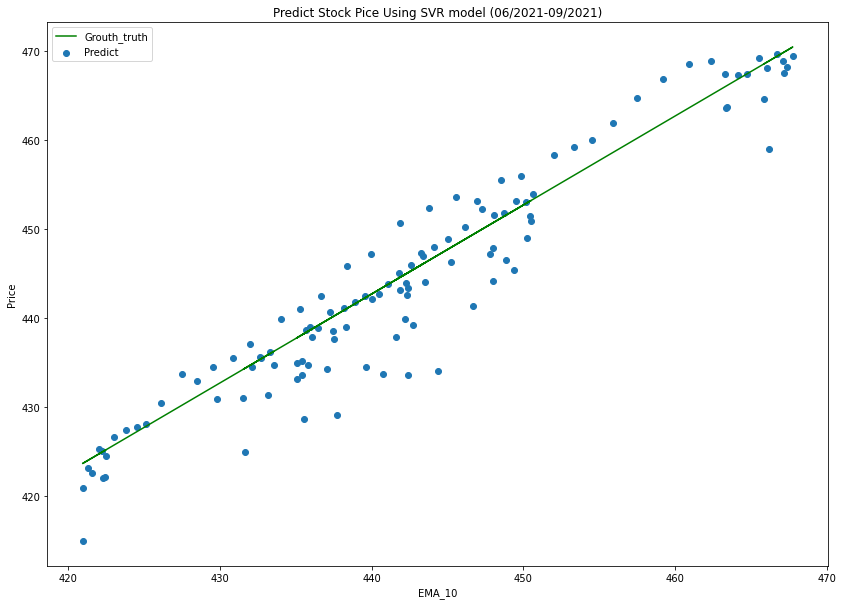

In [19]:
visulizeTest(predSVR, 'Predict Stock Pice Using SVR model (06/2021-09/2021)')

##6.2 Mô hình Linear Regrssion

In [20]:
modelLR, predLR, loss= model(LinearRegression())
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)

Siêu tham số mặc định của mô hình:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 15.94486876790717


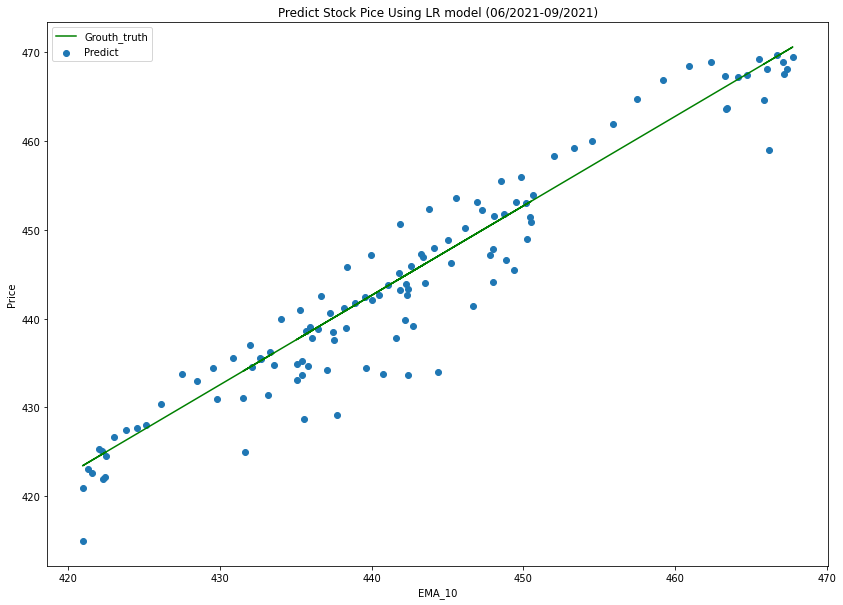

In [21]:
visulizeTest(predLR, 'Predict Stock Pice Using LR model (06/2021-09/2021)')

## 6.3 Mô hình Ridge Regrssion

In [22]:
modelRR, predRR, loss= model(Ridge())
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)

Siêu tham số mặc định của mô hình:  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Độ lỗi mô hình SVR trên tập dứ liệu test: 15.944299583914416


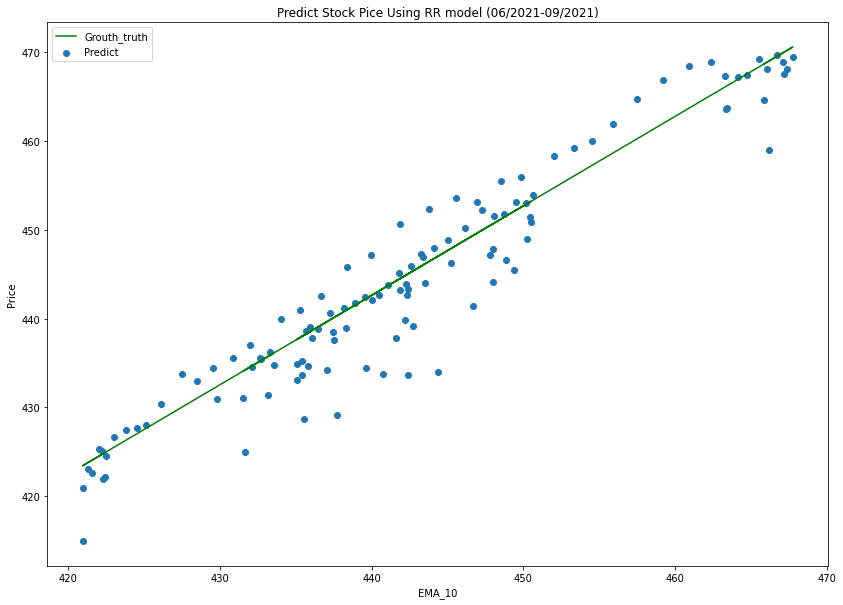

In [23]:
visulizeTest(predRR, 'Predict Stock Pice Using RR model (06/2021-09/2021)')

## 6.3 Mô hình Lasso Regrssion

In [24]:
modelRR, predRR, loss= model(Lasso())
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)

Siêu tham số mặc định của mô hình:  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 15.813547990084675


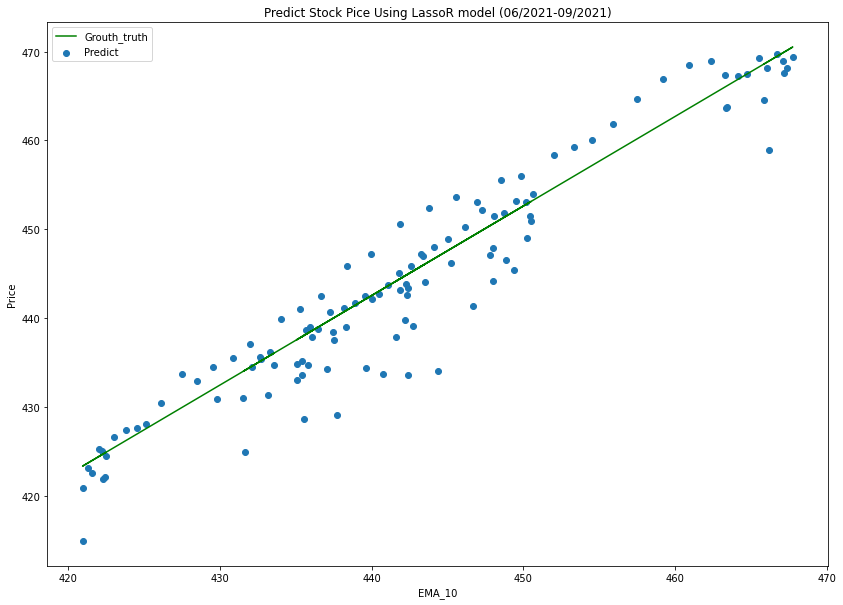

In [25]:
visulizeTest(predRR, 'Predict Stock Pice Using LassoR model (06/2021-09/2021)')

#7. Điều chỉnh siêu tham số của mô hình SVR

In [27]:
list_c = [0.1, 1.0, 10.0, 100.0]
list_epsilon = [0.0, 0.01, 0.1, 0.3, 0.5]
list_kernel =  ['poly', 'rbf', 'linear', 'sigmoid']
list_gamma = [0.1, 0.01, 0.001, 0.0001]
list_degree =  [1, 2, 3, 4]
list_coef0 = [0.0, 0.1, 0.3, 0.5, 1]

##7.1 Sử dụng vòng lặp for

In [32]:
for_best_param = {
    'kernel': None,
    'C': None, 
    'epsilon': None,
    'gamma': None
}

for_best_mse = 16.1

modelForSearch = None

In [ ]:
temp_best_param = {
    'kernel': None,
    'C': None, 
    'epsilon': None,
    'gamma': None
}

start = time.time()
for kernel in list_kernel:
  for C in list_c:
    for epsilon in list_epsilon:
      for gamma in list_gamma:
        temp_param = {
            'kernel': kernel,
            'C': C, 
            'epsilon': epsilon,
            'gamma': gamma
        }
        print("[=> Config: ", temp_param)
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
        start_time = time.time()
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        temp_mse = mean_squared_error(y_test, y_predict)
        print("-> MSE:", temp_mse)
        print("-> Time: {:.4f}s".format(time.time() - start_time))
        if temp_mse < for_best_mse:
          for_best_param = temp_param
          for_best_mse = temp_mse
          modelForSearch = model
        print("============================================")
end = time.time()

[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.1}
-> MSE: 269184181.27241385
-> Time: 1.3611s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.01}
-> MSE: 909.4262586683227
-> Time: 17.2253s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.001}
-> MSE: 283.1919736354097
-> Time: 0.6367s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.0001}
-> MSE: 281.5878677036613
-> Time: 0.0085s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.1}
-> MSE: 872515311.7567221
-> Time: 3.1376s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.01}
-> MSE: 580.106779148054
-> Time: 6.1023s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.001}
-> MSE: 282.88429162558987
-> Time: 0.5165s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.0001}
-> MSE: 281.2109316633629
-> Time: 0.0093s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.1, 'gam

In [1]:
print('Execute time: 7020.5')

Execute time: 7020.5


In [2]:
print("Best Parameters:", for_best_param)
print("Best MSE:", for_best_mse)

Best Parameters: {'kernel': 'linear', 'C': 1.0, 'epsilon': 0.5, 'gamma': 0.1}
Best MSE: 11.727
